In [150]:
import numpy as np
from numpy import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.losses import mse
import seaborn as sns

In [151]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [152]:
latent_dim = 3

encoder_inputs = keras.Input(shape=(3, 1,1))
x = layers.Dense(10, activation="relu")(encoder_inputs)
x = layers.Flatten()(x)
x = layers.Dense(5, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 3, 1, 1)]    0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 3, 1, 10)     20          input_8[0][0]                    
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 30)           0           dense_14[0][0]                   
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 5)            155         flatten_4[0][0]                  
____________________________________________________________________________________________

In [153]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(10, activation="relu")(latent_inputs)
x = layers.Dense(3, activation="relu")(x)
decoder_outputs = layers.Reshape((3, 1,1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                40        
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 33        
_________________________________________________________________
reshape_3 (Reshape)          (None, 3, 1, 1)           0         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


In [154]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                mse(data, reconstruction)
            )
            reconstruction_loss *= 3
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [170]:
def gen_data(ind,firm,length):
    random.seed(50)
    indid = np.random.choice(ind,length)
    firmid = np.random.choice(firm,length)
    indfe = np.random.normal(size=ind)+5
    firmfe = np.random.normal(size=firm)+10
    w = indfe[indid] + firmfe[firmid] + 0.1*np.random.normal(size=length)
    data = np.transpose(np.array([w,indid,firmid]))
    return {'data':data, 'indfe':indfe, 'firmfe':firmfe}

In [ ]:
rs=gen_data(20,30,10000)

In [172]:
data=rs['data']


In [173]:


vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(data.reshape((data.shape[0],3,1,1)), epochs=150, batch_size=128)

Epoch 1/150
79/79 [==============================] - 0s 1ms/step - loss: 214.6751 - reconstruction_loss: 211.5224 - kl_loss: 3.1527
Epoch 2/150
79/79 [==============================] - 0s 1ms/step - loss: 119.6634 - reconstruction_loss: 107.8363 - kl_loss: 11.8271
Epoch 3/150
79/79 [==============================] - 0s 1ms/step - loss: 45.3026 - reconstruction_loss: 27.5585 - kl_loss: 17.7441
Epoch 4/150
79/79 [==============================] - 0s 1ms/step - loss: 33.0740 - reconstruction_loss: 19.8276 - kl_loss: 13.2464
Epoch 5/150
79/79 [==============================] - 0s 1ms/step - loss: 25.4041 - reconstruction_loss: 14.5830 - kl_loss: 10.8211
Epoch 6/150
79/79 [==============================] - 0s 1ms/step - loss: 19.9959 - reconstruction_loss: 10.4377 - kl_loss: 9.5581
Epoch 7/150
79/79 [==============================] - 0s 1ms/step - loss: 16.7953 - reconstruction_loss: 8.2603 - kl_loss: 8.5350
Epoch 8/150
79/79 [==============================] - 0s 1ms/step - loss: 14.3712 - 

In [174]:
est = decoder.predict(encoder(data.reshape((data.shape[0],3,1,1)))).reshape(data.shape[0],3)[:,0]
real=rs['data'][:,0]

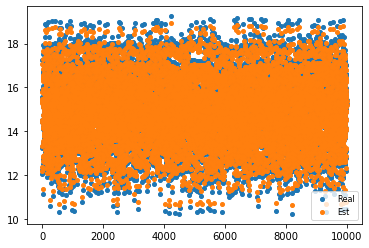

In [175]:
fig,ax=plt.subplots()
label=[]
ax.plot(real,'o',markersize=4)
label=label+['Real']
ax.plot(est,'o',markersize=4)
label=label+['Est']
plt.legend(label,fontsize=8)


In [186]:
est_firm=encoder.predict(data.reshape((data.shape[0],3,1,1)))[2][:,1]
real_firm=rs['firmfe'][rs['data'][:,2].astype(int)]

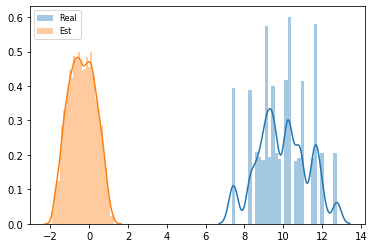

In [187]:

label=[]
sns.distplot(real_firm)
label=label+['Real']
sns.distplot(est_firm)
label=label+['Est']
plt.legend(label,fontsize=8)

In [188]:
est_ind=encoder.predict(data.reshape((data.shape[0],3,1,1)))[2][:,2]
real_ind=rs['indfe'][rs['data'][:,1].astype(int)]

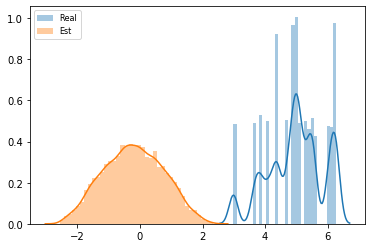

In [189]:
label=[]
sns.distplot(real_ind)
label=label+['Real']
sns.distplot(est_ind)
label=label+['Est']
plt.legend(label,fontsize=8)

In [190]:
est_eps=encoder.predict(data.reshape((data.shape[0],3,1,1)))[2][:,0]


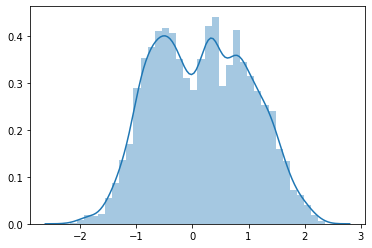

In [191]:
label=[]
sns.distplot(est_eps)

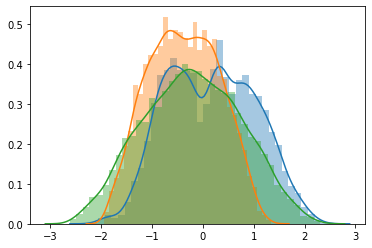

In [192]:
sns.distplot(encoder.predict(data.reshape((data.shape[0],3,1,1)))[2][:,0])
sns.distplot(encoder.predict(data.reshape((data.shape[0],3,1,1)))[2][:,1])
sns.distplot(encoder.predict(data.reshape((data.shape[0],3,1,1)))[2][:,2])


Text(0, 0.5, 'z[2]')

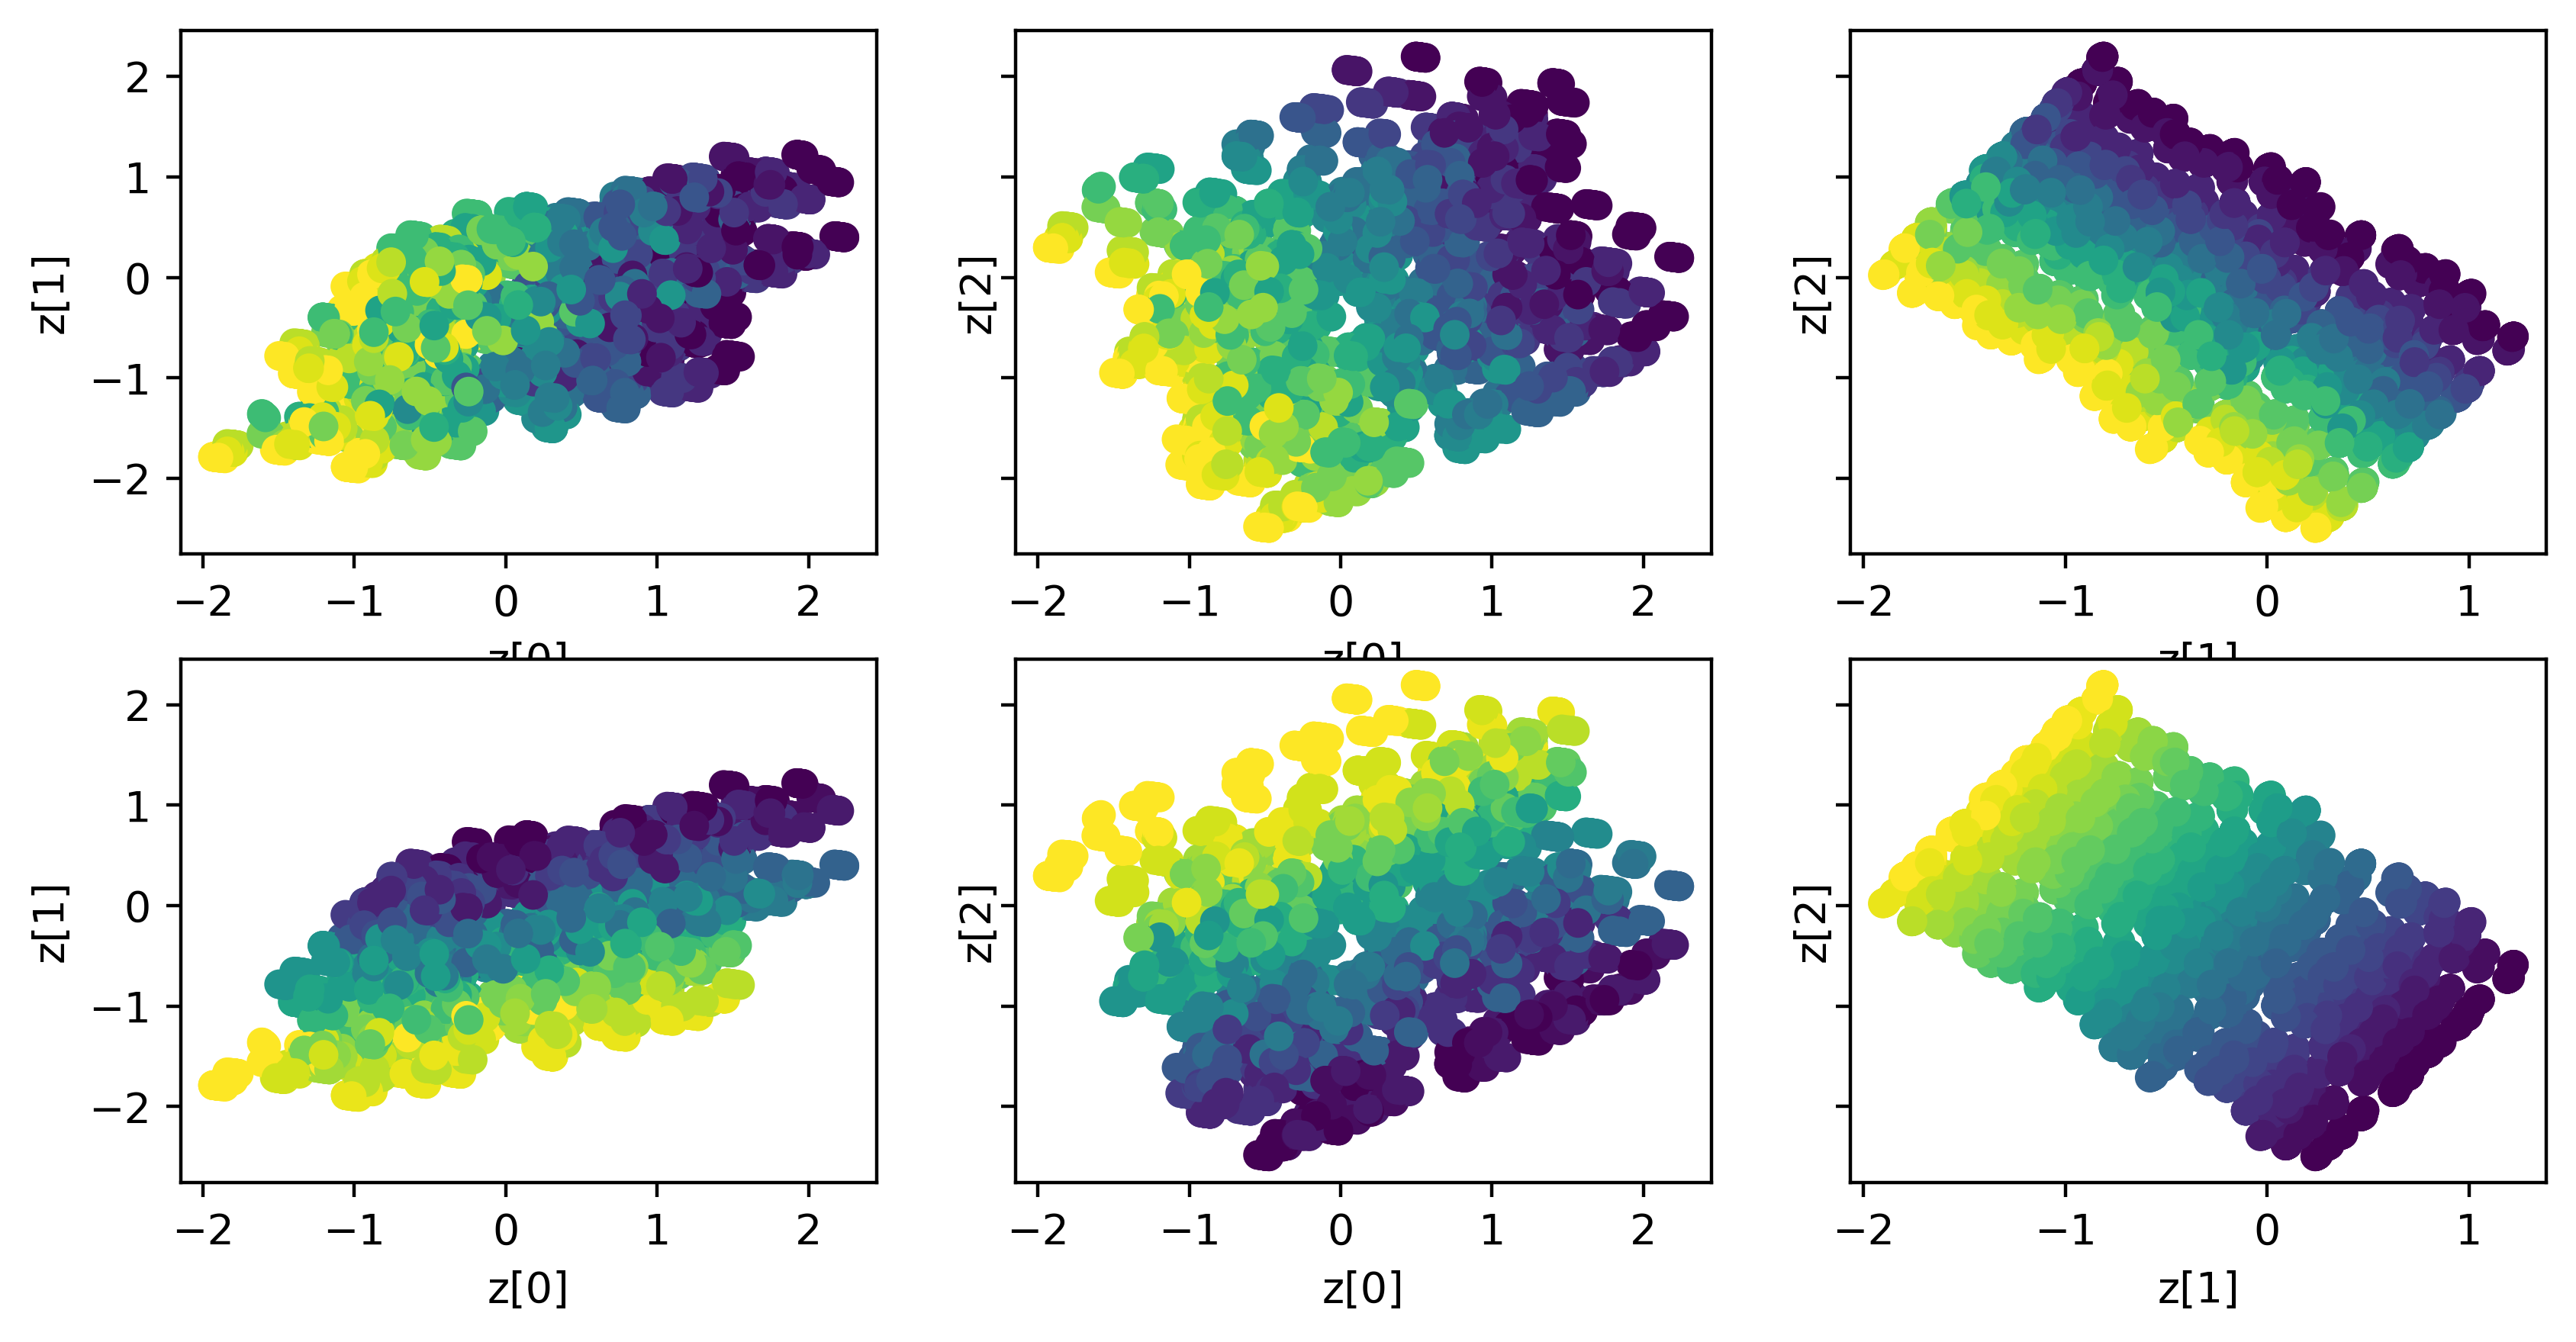

In [201]:
fig, ax = plt.subplots(2, 3, figsize=(10, 5),  dpi=400, sharey='row')
z_mean, _, _ = encoder.predict(data.reshape((data.shape[0],3,1,1)))

labels=rs['data'][:,1].astype(int)

ax[0,0].scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
ax[0,0].set_xlabel("z[0]")
ax[0,0].set_ylabel("z[1]")

ax[0,1].scatter(z_mean[:, 0], z_mean[:, 2], c=labels)
ax[0,1].set_xlabel("z[0]")
ax[0,1].set_ylabel("z[2]")

ax[0,2].scatter(z_mean[:, 1], z_mean[:, 2], c=labels)
ax[0,2].set_xlabel("z[1]")
ax[0,2].set_ylabel("z[2]")

labels=rs['data'][:,2].astype(int)

ax[1,0].scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
ax[1,0].set_xlabel("z[0]")
ax[1,0].set_ylabel("z[1]")

ax[1,1].scatter(z_mean[:, 0], z_mean[:, 2], c=labels)
ax[1,1].set_xlabel("z[0]")
ax[1,1].set_ylabel("z[2]")

ax[1,2].scatter(z_mean[:, 1], z_mean[:, 2], c=labels)
ax[1,2].set_xlabel("z[1]")
ax[1,2].set_ylabel("z[2]")
